In [1]:
import csv
import pandas as pd
import math
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt



def preprocessDate(df)  :
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayOfWeek'] = df['Date'].dt.dayofweek
    
    del df['Date']
    return df

def preprocessLabeledCategorical(data, df) : 
    countries = df['Country'].tolist() 
    le = preprocessing.LabelEncoder()
    le.fit(countries)
    # print(list(le.classes_))
    transformedCountries = le.transform(countries)
    for i in range(len(data)) : 
        data[i]['Country'] = transformedCountries[i]
    
    return data

def scaleData(data):
    scalableData = []
    for row in data:
        scalableData.append([row["Total Quantity"], row["Total Price"]])
    
    scaler = StandardScaler()
    scaler.fit(scalableData)
    transformedData = scaler.transform(scalableData)
    
    for i in range(len(data)) :
        data[i]['Total Quantity'] = transformedData[i][0]
        data[i]['Total Price'] = transformedData[i][1]
    
    return data                            

def getProcessedData(dataFile, encodingType) : 
    data = []
    targetData = []
    col_list = ["Customer ID", "Total Quantity", "Total Price", "Country", "Date", "Is Back", "Purchase Count"]
    df = pd.read_csv(dataFile, usecols=col_list)
    df['Date']= pd.to_datetime(df['Date'])
    
    if (encodingType == "oneHot") :
        df = pd.concat([df,pd.get_dummies(df['Country'], prefix = "country")],axis=1).drop(['Country'],axis=1)


    
    df = preprocessDate(df)
    
    for index, dfRow in df.iterrows() : 
        if (dfRow['Is Back'] == 'Yes') : 
            dfRow['Is Back'] = 1
        else:
            dfRow['Is Back'] = 0
            
        targetData.append(dfRow['Is Back'])    
        del dfRow['Is Back']
        del dfRow['Customer ID']
        data.append(dfRow)
        
    if (encodingType == "labeled") :
        preprocessLabeledCategorical(data, df)
        
    data = scaleData(data)
    
    labels = list(df)
    labels.remove('Customer ID')
    labels.remove('Is Back')
    return [data, targetData, labels]

In [2]:
[data, targetData, labels] = getProcessedData("data.csv", "oneHot") #second parameter: "labeled" or "oneHot"

informationGains = mutual_info_classif(data, targetData)
informationGains

array([0.        , 0.01340006, 0.00590566, 0.00718247, 0.        ,
       0.0036053 , 0.00637369, 0.        , 0.00144002, 0.        ,
       0.0008154 , 0.00011885, 0.00607654, 0.00215865, 0.00096311,
       0.        , 0.        , 0.        , 0.        , 0.00218761,
       0.        , 0.00212975, 0.0062876 , 0.00548246, 0.00829592,
       0.00492564, 0.01270294, 0.01790304, 0.        , 0.00170715,
       0.        , 0.00782431, 0.00745416, 0.00091302, 0.01202946,
       0.        , 0.        , 0.00157117, 0.00052424, 0.        ,
       0.03305948, 0.06521856, 0.02080194, 0.01087791])

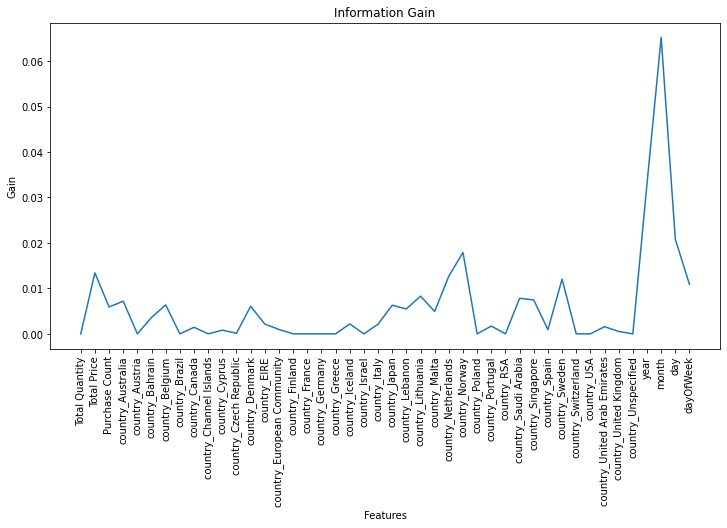

In [3]:
def showInformationGains() :
    plt.figure(figsize=(12, 6))
    plt.plot(informationGains) 
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.xlabel('Features') 
    plt.ylabel('Gain') 
    plt.title('Information Gain') 

    plt.show()
showInformationGains()

phase1: knn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

trainData, testData, trainTarget, testTarget = train_test_split(data, targetData, test_size=0.20, random_state=30)


def classifyKnn(n = 8) : 
    knnTestPredic = []
    knnTrainPredic = []
    
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(trainData, trainTarget)
    
    knnTestPredic = neigh.predict(testData)
       
    knnTrainPredic = neigh.predict(trainData)
        
    return [knnTrainPredic, knnTestPredic]

def classifyDecisionTree(d = 4) : 
    treeTestPredic = []
    treeTrainPredic = []
    
    clf = DecisionTreeClassifier(random_state=10, max_depth=d)
    clf.fit(trainData, trainTarget)
     
    treeTestPredic = clf.predict(testData)
    
    treeTrainPredic = clf.predict(trainData)
        
    return [treeTrainPredic, treeTestPredic]
    
def classifyLogistic() : 
    logisticTestPredic = []
    logisticTrainPredic = []
    
    clf = LogisticRegression().fit(trainData, trainTarget)
    
    
    logisticTestPredic = clf.predict(testData)
    
    logisticTrainPredic = clf.predict(trainData)
        
    return [logisticTrainPredic, logisticTestPredic]
    
knnPredictions = classifyKnn()
treePredictions = classifyDecisionTree()
logisticPredictions = classifyLogistic()

In [58]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

def showPrecisions() : 
    knnTrainPrecision = "{:.2f}".format(average_precision_score(trainTarget, knnPredictions[0]) * 100)
    knnTestPrecision = "{:.2f}".format(average_precision_score(testTarget, knnPredictions[1]) * 100)

    treeTrainPrecision = "{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)
    treeTestPrecision = "{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)
    
    logisticTrainPrecision = "{:.2f}".format(average_precision_score(trainTarget, logisticPredictions[0]) * 100)
    logisticTestPrecision = "{:.2f}".format(average_precision_score(testTarget, logisticPredictions[1]) * 100)
    
    
    df2 = pd.DataFrame (columns = ['Precision', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Precision'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

def showAccuracy() : 
    knnTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, knnPredictions[0]) * 100)
    knnTestPrecision = "{:.2f}".format(accuracy_score(testTarget, knnPredictions[1]) * 100)

    treeTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)
    treeTestPrecision = "{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)
    
    logisticTrainPrecision = "{:.2f}".format(accuracy_score(trainTarget, logisticPredictions[0]) * 100)
    logisticTestPrecision = "{:.2f}".format(accuracy_score(testTarget, logisticPredictions[1]) * 100)
    
    
    df2 = pd.DataFrame (columns = ['Accuracy', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Accuracy'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

def showRecall() : 
    knnTrainPrecision = "{:.2f}".format(recall_score(trainTarget, knnPredictions[0], average = 'weighted') * 100)
    knnTestPrecision = "{:.2f}".format(recall_score(testTarget, knnPredictions[1], average = 'weighted') * 100)

    treeTrainPrecision = "{:.2f}".format(recall_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestPrecision = "{:.2f}".format(recall_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    logisticTrainPrecision = "{:.2f}".format(recall_score(trainTarget, logisticPredictions[0], average = 'weighted') * 100)
    logisticTestPrecision = "{:.2f}".format(recall_score(testTarget, logisticPredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Recall', 'KNN', 'Decision Tree', 'Logistic'])
    df2['Recall'] = ['Train', 'Test']
    df2['KNN'] = [knnTrainPrecision, knnTestPrecision]
    df2['Decision Tree'] = [treeTrainPrecision, treeTestPrecision]
    df2['Logistic'] = [logisticTrainPrecision, logisticTestPrecision]
    
    return df2

In [59]:
showPrecisions()

,Precision,KNN,Decision Tree,Logistic
0,Train,77.34,76.42,68.46
1,Test,75.60,76.53,70.05


In [60]:
showAccuracy()

,Accuracy,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [61]:
showRecall()

,Recall,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [62]:
it = 16
def showKnnAccuracyDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        knnPredictions = classifyKnn(i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, knnPredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, knnPredictions[1]) * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Neighbors') 
    plt.ylabel('Accuracy') 
    plt.title('KNN Accuracy') 
        
    plt.show()
    
def showDecisionTreeAccuracyDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = classifyDecisionTree(i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Accuracy') 
    plt.title('Decision Tree Accuracy') 
        
    plt.show()

def showKnnPrecisionDiagram() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        knnPredictions = classifyKnn(i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, knnPredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, knnPredictions[1]) * 100)))

    plt.figure(figsize=(12, 10))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Neighbors') 
    plt.ylabel('Precision') 
    plt.title('KNN Precision') 

    plt.show()
    
def showDecisionTreePrecisionDiagram() :
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = classifyDecisionTree(i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))
        
    plt.figure(figsize=(12, 10))
    
    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Precision') 
    plt.title('Decision Tree Precision') 
        
    plt.show()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

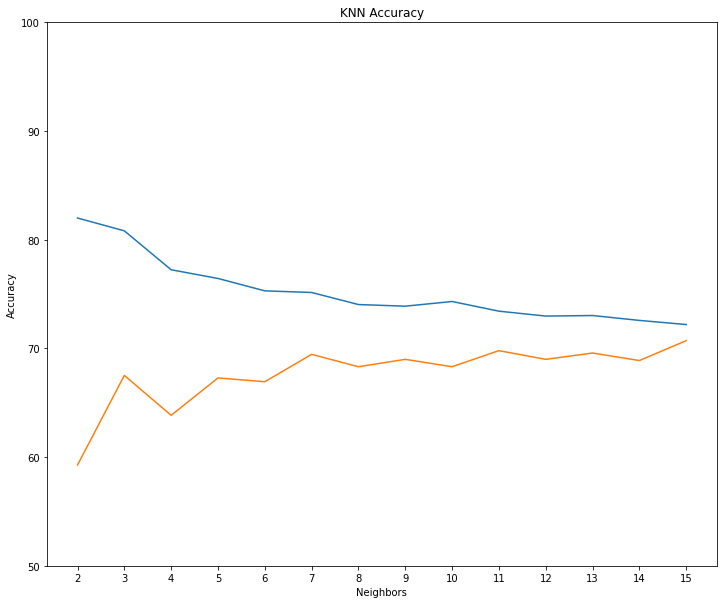

In [63]:
showKnnAccuracyDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

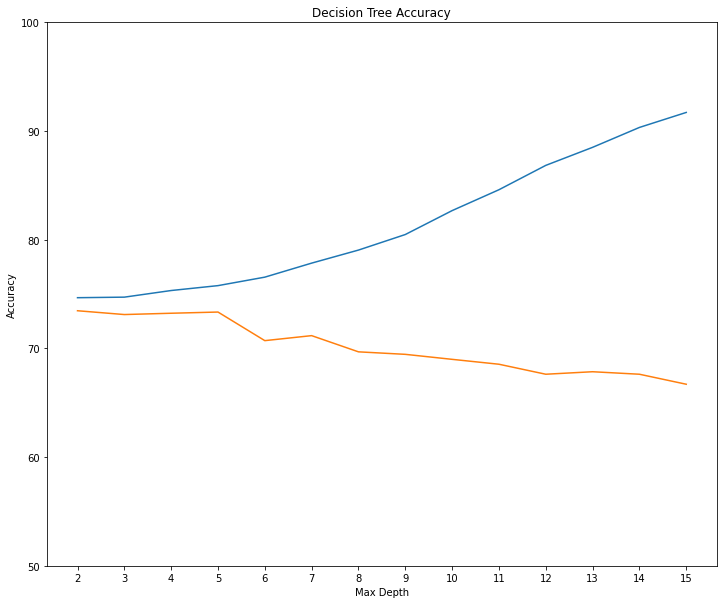

In [64]:
showDecisionTreeAccuracyDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

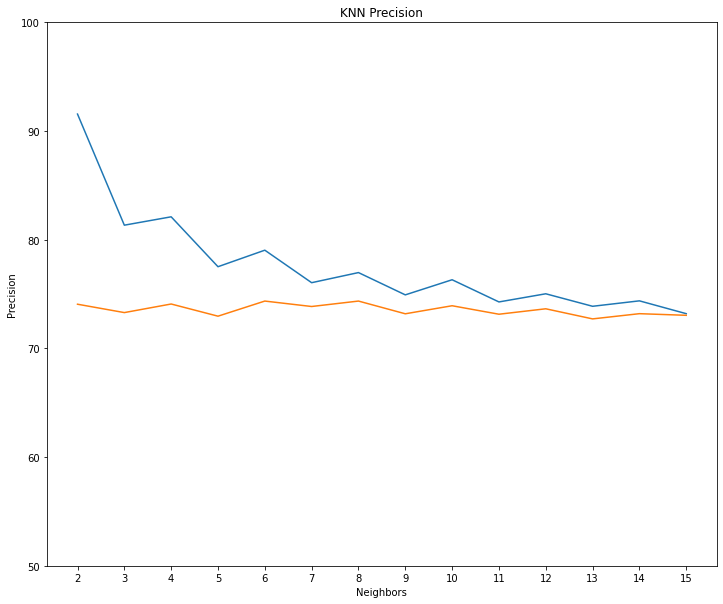

In [65]:
showKnnPrecisionDiagram()

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

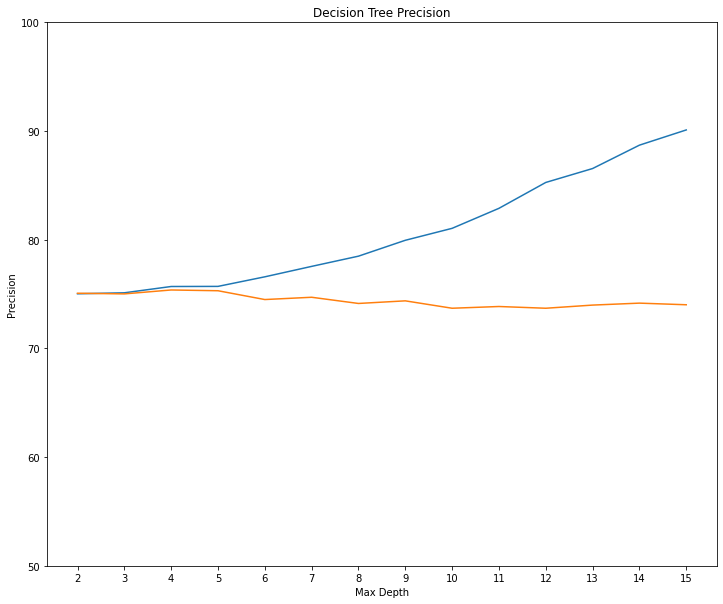

In [66]:
showDecisionTreePrecisionDiagram()

phase2

In [67]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

def evaluateKNNBagging() :
    knnTestPredic = []
    knnTrainPredic = []
    clf = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=8), 
                            max_samples = 0.5, max_features = 0.5, n_estimators=3, random_state=0).fit(trainData, trainTarget)

    knnTestPredic = clf.predict(testData)

    knnTrainPredic = clf.predict(trainData)
        
    return [knnTrainPredic, knnTestPredic]
    
knnPredictions = evaluateKNNBagging()  

def evaluateDecisionTreeBagging() :
    TreeTestPredic = []
    TreeTrainPredic = []
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), 
                            max_samples = 0.5, max_features = 0.5, n_estimators=3, random_state=0).fit(trainData, trainTarget)

    TreeTestPredic = clf.predict(testData)

    TreeTrainPredic = clf.predict(trainData)
        
    return [TreeTrainPredic, TreeTestPredic]
    
knnPredictions = evaluateKNNBagging() 
treePredictions = evaluateDecisionTreeBagging()

evaluateKNNBagging()
evaluateDecisionTreeBagging()

print("In tables below, forth column: Logistic is not related to current phase, it is related to phase1")
    

In tables below, forth column: Logistic is not related to current phase, it is related to phase1


In [68]:
showPrecisions()

,Precision,KNN,Decision Tree,Logistic
0,Train,77.34,76.42,68.46
1,Test,75.60,76.53,70.05


In [69]:
showAccuracy()

,Accuracy,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [70]:
showRecall()

,Recall,KNN,Decision Tree,Logistic
0,Train,75.34,74.00,68.61
1,Test,70.59,72.54,70.14


In [97]:
from sklearn.ensemble import RandomForestClassifier

def evaluateRandomForest(type = "max_depth", d = 4) : 
    TreeTestPredic = []
    TreeTrainPredic = []
    
    if (type == "max_depth") : 
        clf = RandomForestClassifier(max_depth=d, random_state=0, n_estimators=3, max_features=0.5, max_samples=0.5)
    elif (type == "max_leaf") : 
        clf = RandomForestClassifier(max_depth=4, max_leaf_nodes = d, random_state=0, n_estimators=3, max_features=0.5, max_samples=0.5)
    elif (type == "max_features") : 
        clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=3, max_features=d, max_samples=0.5)
        
    clf.fit(trainData, trainTarget)
    
    TreeTestPredic = clf.predict(testData)

    TreeTrainPredic = clf.predict(trainData)
        
    return [TreeTrainPredic, TreeTestPredic]

def showRandomForestSpecifications(type = "max_depth", d = 4) : 
    treePredictions = evaluateRandomForest(type, d)
    
    treeTrainPrecision = "{:.2f}".format(precision_score(trainTarget, treePredictions[0]) * 100)
    treeTestPrecision = "{:.2f}".format(precision_score(testTarget, treePredictions[1]) * 100)

    treeTrainAccuracy = "{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)
    treeTestAccuracy = "{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)
    
    treeTrainRecall = "{:.2f}".format(recall_score(trainTarget, treePredictions[0], average = 'weighted') * 100)
    treeTestRecall = "{:.2f}".format(recall_score(testTarget, treePredictions[1], average = 'weighted') * 100)
    
    
    df2 = pd.DataFrame (columns = ['Random Forest', 'Precision', 'Accuracy', 'Recall'])
    
    df2['Random Forest'] = ['Train', 'Test']
    df2['Precision'] = [treeTrainPrecision, treeTestPrecision]
    df2['Accuracy'] = [treeTrainAccuracy, treeTestAccuracy]
    df2['Recall'] = [treeTrainRecall, treeTestRecall]
    
    return df2

showRandomForestSpecifications()

,Random Forest,Precision,Accuracy,Recall
0,Train,76.89,74.37,74.37
1,Test,76.64,72.08,72.08


In [123]:
it = 15
def showRFMaxDepthPrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_depth", i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max depth') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxDepthAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_depth", i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Depth') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show()
    
def showRFMaxLeafPrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_leaf", i)
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 6))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Leaf Nodes') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxLeafAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append(i)
        treePredictions = evaluateRandomForest("max_leaf", i)
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 8))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Leaf Nodes') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show() 
    
def showRFMaxFeaturePrecisionRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append("{:.2f}".format(i * 100 / it))
        treePredictions = evaluateRandomForest("max_features", (float)(i / it))
        trainPrecisions.append((float)("{:.2f}".format(average_precision_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(average_precision_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 8))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Features') 
    plt.ylabel('Precision') 
    plt.title('Random Forest Precision') 

    plt.show() 
    
def showRFMaxFeatureAccuracyRange() : 
    trainPrecisions = []
    testPrecisions = []
    labels = []
    for i in range(2, it) : 
        print(i, end = " ")
        labels.append("{:.2f}".format(i * 100 / it))
        treePredictions = evaluateRandomForest("max_features", (float)(i / it))
        trainPrecisions.append((float)("{:.2f}".format(accuracy_score(trainTarget, treePredictions[0]) * 100)))
        testPrecisions.append((float)("{:.2f}".format(accuracy_score(testTarget, treePredictions[1]) * 100)))

    plt.figure(figsize=(10, 8))

    plt.plot(trainPrecisions) 
    plt.plot(testPrecisions) 
    plt.ylim(50, 100)
    plt.xticks(range(len(labels)), labels)
    plt.xlabel('Max Features') 
    plt.ylabel('Accuracy') 
    plt.title('Random Forest Accuracy') 

    plt.show()        

2 3 4 5 6 7 8 9 10 11 12 13 14 

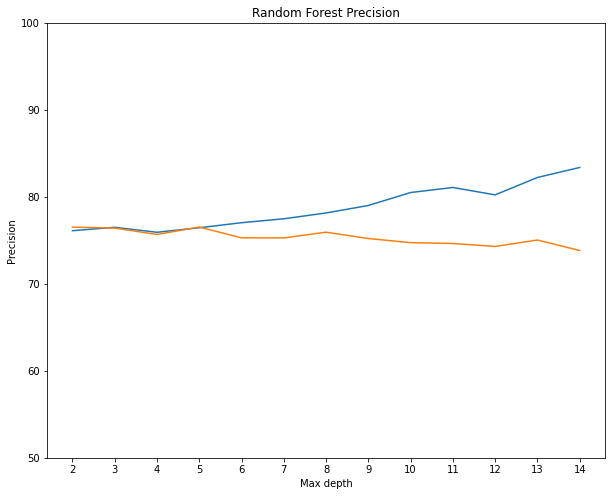

In [124]:
showRFMaxDepthPrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

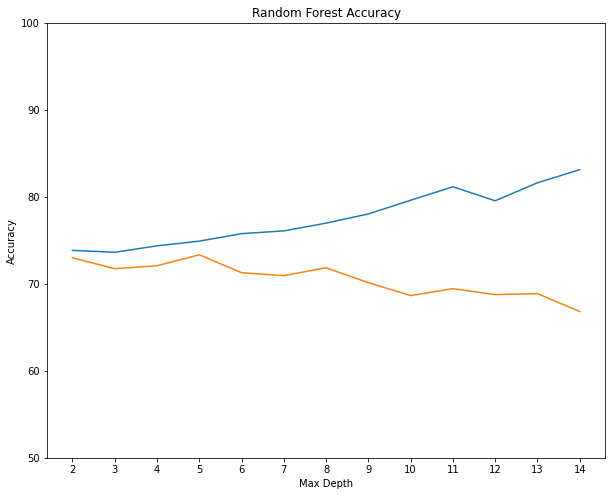

In [125]:
showRFMaxDepthAccuracyRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

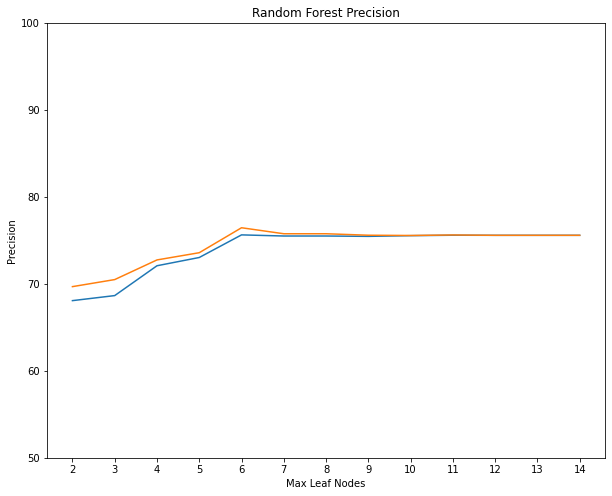

In [126]:
showRFMaxLeafPrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

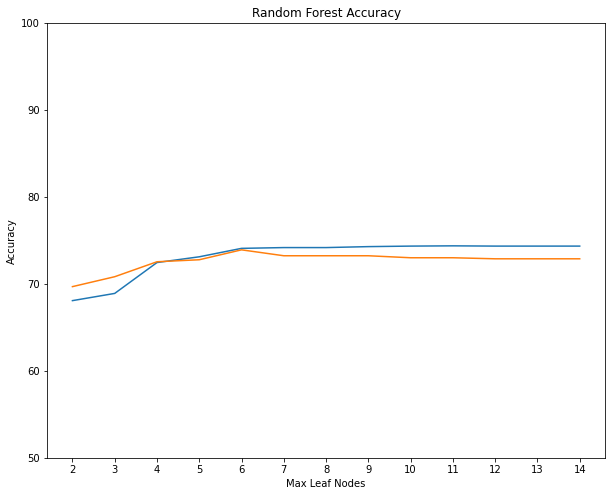

In [127]:
showRFMaxLeafAccuracyRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

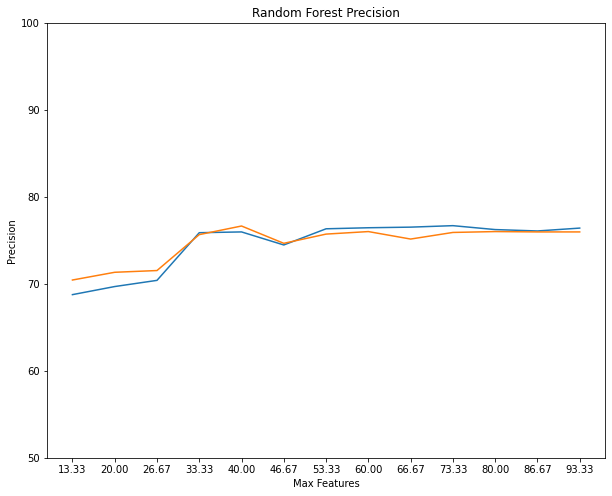

In [128]:
showRFMaxFeaturePrecisionRange()

2 3 4 5 6 7 8 9 10 11 12 13 14 

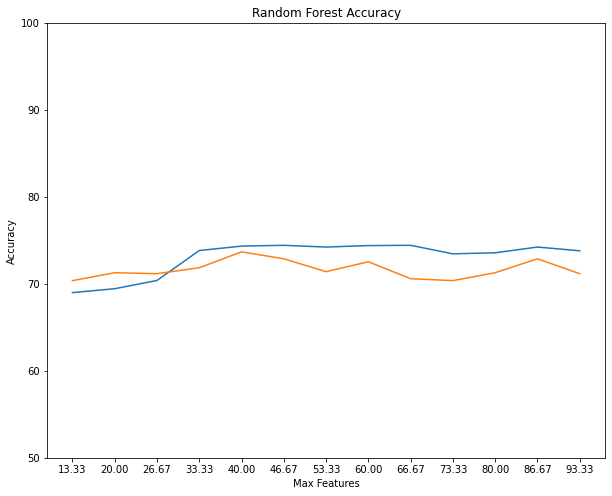

In [129]:
showRFMaxFeatureAccuracyRange()